# Churn Dataset EDA

This notebook provides a quick sanity-check EDA for the synthetic churn data.
It expects offline features stored in S3 under the layout used by the project:

```
s3://<OFFLINE_BUCKET>/churn/features/dt=YYYY-MM-DD/part-0000.parquet
```

**Columns**: `age`, `tenure_months`, `is_promo_user`, `label`.

**Instructions**:
1. Set the S3 variables below.
2. Run the Notebook top to bottom.
3. Use the quick plots and stats to validate data health.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()

True

In [6]:
# --- Config ---
OFFLINE_BUCKET = os.getenv("OFFLINE_BUCKET")# change if needed
DATE_PARTITION = '2025-08-01'               # set to the partition you generated
READ_MULTIPLE_PARTS = False                 # set True to read multiple partitions via a prefix

# If True, reads prefix s3://ml-offline/churn/features/dt=<DATE_PARTITION>/
# If False, reads just part-0000.parquet

In [7]:
# --- Load data from S3 ---
if READ_MULTIPLE_PARTS:
    # read all files under the partition
    prefix = f's3://{OFFLINE_BUCKET}/churn/features/dt={DATE_PARTITION}/'
    # pandas will expand prefixes when using wildcard
    df = pd.read_parquet(prefix)
else:
    path = f's3://{OFFLINE_BUCKET}/churn/features/dt={DATE_PARTITION}/part-0000.parquet'
    df = pd.read_parquet(path)

print(df.shape)
df.head()

(25000, 4)


,age,tenure_months,is_promo_user,label
0,18,31,0,1
1,56,45,0,1
2,51,23,0,0
3,21,18,0,0
4,69,56,0,0


In [8]:
# --- Basic schema & missingness checks ---
expected_cols = ['age','tenure_months','is_promo_user','label']
missing = [c for c in expected_cols if c not in df.columns]
assert not missing, f'Missing expected columns: {missing}'

display(df.dtypes)
display(df.isna().mean().rename('missing_rate'))

# simple stats
display(df.describe(include='all'))

age              int64
tenure_months    int64
is_promo_user    int64
label            int64
dtype: object

age              0.0
tenure_months    0.0
is_promo_user    0.0
label            0.0
Name: missing_rate, dtype: float64

,age,tenure_months,is_promo_user,label
count,25000.000000,25000.00000,25000.000000,25000.00000
mean,45.850480,29.84720,0.303560,0.16684
std,16.417684,17.05802,0.459804,0.37284
min,18.000000,1.00000,0.000000,0.00000
25%,32.000000,15.00000,0.000000,0.00000
50%,46.000000,30.00000,0.000000,0.00000
75%,60.000000,45.00000,1.000000,0.00000
max,74.000000,59.00000,1.000000,1.00000


label
0    20829
1     4171
Name: count, dtype: int64


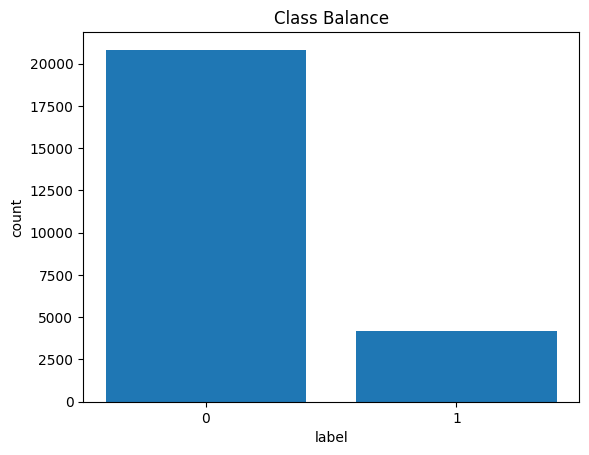

In [9]:
# --- Class balance ---
counts = df['label'].value_counts().sort_index()
print(counts)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(counts.index.astype(str), counts.values)
ax.set_xlabel('label')
ax.set_ylabel('count')
ax.set_title('Class Balance')
plt.show()

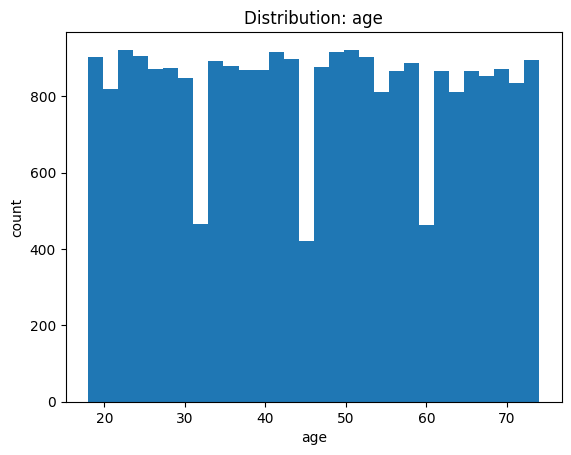

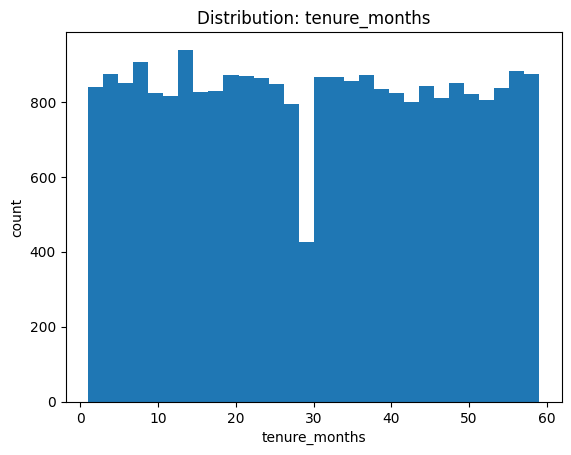

In [10]:
# --- Histograms for numerical columns ---
for col in ['age','tenure_months']:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(df[col].dropna(), bins=30)
    ax.set_xlabel(col)
    ax.set_ylabel('count')
    ax.set_title(f'Distribution: {col}')
    plt.show()

Promo user rate: 0.30356
Churn rate by is_promo_user:
is_promo_user
0    0.191718
1    0.109764
Name: label, dtype: float64


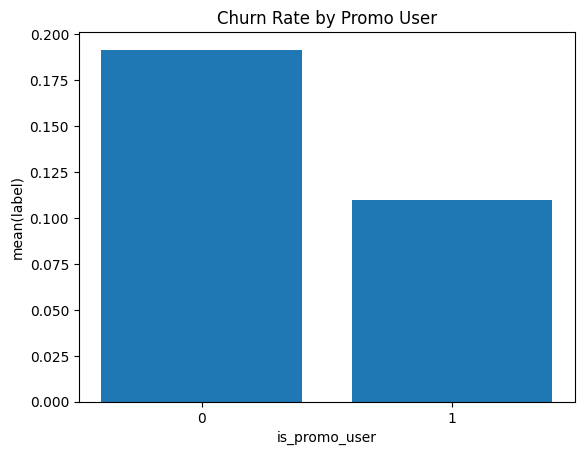

In [11]:
# --- Promo flag rate and label rate by promo ---
promo_rate = df['is_promo_user'].mean()
print('Promo user rate:', promo_rate)

group = df.groupby('is_promo_user')['label'].mean()
print('Churn rate by is_promo_user:')
print(group)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(group.index.astype(str), group.values)
ax.set_xlabel('is_promo_user')
ax.set_ylabel('mean(label)')
ax.set_title('Churn Rate by Promo User')
plt.show()

                    age  tenure_months  is_promo_user     label
age            1.000000       0.007532       0.011540 -0.090910
tenure_months  0.007532       1.000000       0.000635 -0.177856
is_promo_user  0.011540       0.000635       1.000000 -0.101069
label         -0.090910      -0.177856      -0.101069  1.000000


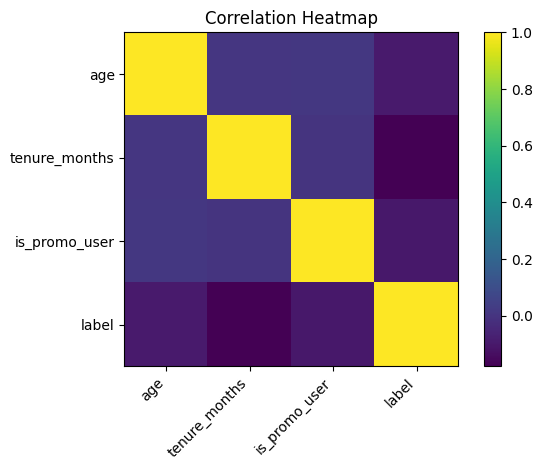

In [12]:
# --- Correlation heatmap (numeric only) ---
num_df = df[['age','tenure_months','is_promo_user','label']].astype(float)
corr = num_df.corr()
print(corr)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(corr.values, interpolation='nearest')
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)
ax.set_title('Correlation Heatmap')
fig.colorbar(cax)
plt.tight_layout()
plt.show()

In [13]:
# --- Simple train/val split sanity (no training here) ---
from sklearn.model_selection import train_test_split

X = df[['age','tenure_months','is_promo_user']].copy()
y = df['label'].astype(int)

Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train size:', Xtr.shape, 'Val size:', Xval.shape)
print('Train churn rate:', ytr.mean(), 'Val churn rate:', yval.mean())

Train size: (20000, 3) Val size: (5000, 3)
Train churn rate: 0.16685 Val churn rate: 0.1668
